# Лабораторная работа: Анализ динамических систем
## Цель: 
Освоить численное решение систем ДУ, построение фазовых портретов в различных координатах, линеаризацию и анализ устойчивости.

---

## Часть 1: Линейные системы (2D)

Мы будем рассматривать систему:
$$\dot{x}=4x-t^2x,\quad x(0)=0$$

### Блок 1.1: Импорт библиотек

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sp
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

### Блок 1.2: Определение системы

In [2]:
def linear_system(t, state):
    x, y = np.asarray(state)
    dxdt = 4 * x - t**2 * x
    dydt = 0
    return np.array([dxdt, dydt])

### Блок 1.3: Фазовый портрет

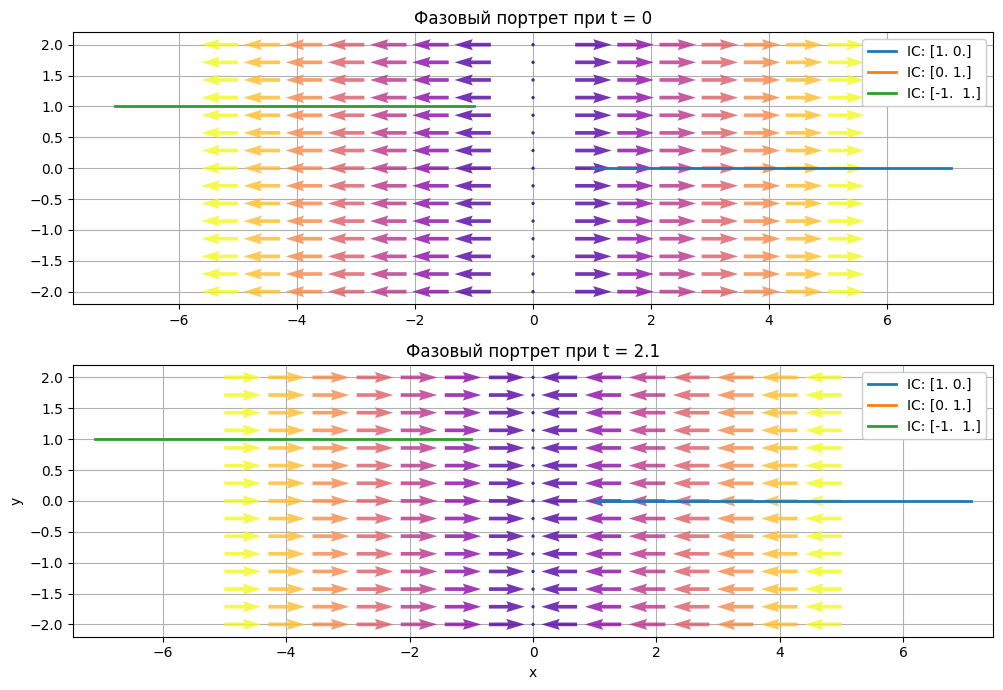

In [3]:
initial_conditions = [[1, 0], [0, 1], [-1, 1]]
solutions = []
time_interval = (0, 0.5)
for ic in initial_conditions:
    sol = solve_ivp(linear_system, time_interval, ic, t_eval=np.linspace(time_interval[0], time_interval[1], 1000))
    solutions.append(sol)
    
x_vals = np.linspace(-5, 5, 15)
y_vals = np.linspace(-2, 2, 15)
X, Y = np.meshgrid(x_vals, y_vals)

dX = np.zeros((2, X.shape[0], X.shape[1]))
dY = np.zeros_like(dX)

t = [0, 2.1]

for idx, t_i in enumerate(t):
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            dx, dy = linear_system(t_i, [X[i, j], Y[i, j]])
            dX[idx, i, j] = dx
            dY[idx, i, j] = dy

fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharey=True)
for i, ax in enumerate(axes):
    norm = np.sqrt(dX[i]**2 + dY[i]**2)
    dX_scaled = dX[i] / (norm + 0.01)
    dY_scaled = dY[i] / (norm + 0.01)
    ax.quiver(X, Y, dX_scaled, dY_scaled, norm, cmap='plasma', alpha=0.8)

    for sol in solutions:
        ax.plot(sol.y[0], sol.y[1], lw=2, label=f"IC: {sol.y[:,0]}")


    ax.grid(True)
    ax.legend(framealpha=1.0)
    ax.set_axisbelow(True)
    ax.set_title(f"Фазовый портрет при t = {t[i]}")

plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.axis('equal')
plt.show()

#### Как собственные значения матрицы системы связаны с фазовыми портретом?
 
##### Устойчивоcть:
- Если оба $\text{Re}(\lambda)<0$: решения стремятся к началу координат — устойчивый узел или фокус
- Еcли оба $\text{Re}(\lambda)>0$: решения уходят от начала координат — неустойчивый узел или фокус
- Если $\text{Re}(\lambda)$ имеют разные знаки: есть направление притяжения и отталкивания — седло (всегда неустойчиво)

##### Тип траекторий
- Действительные и разные $\lambda$: фазовый портрет — узел (линии вдоль направлений собственных векторов)
- Действительные и противоположные $\lambda$: седло (траектории вдоль одного направления сходятся, вдоль другого — расходятся)

##### Комплексные $\lambda$:
- Если $\text{Re}(\lambda)\neq0$: фокус (спираль, закручивающаяся или раскручивающаяся)
- Если $\text{Re}(\lambda)=0$: центр (замкнутые орбиты, как окружности или эллипсы)

**В нашем случае, поскольку $y$ не дан, по данному направлению будем считать, что $\dot{y}=0$, и при $t\in[0,2)$ траектории убегают от центра, а при $t\in[2,+\infty)$ сходятся к центру обратно.** 

## Часть 2: Нелинейные системы (2D)

Система: 
$$
\begin{cases}
\dot{x} = y + x(1 - x^2 - y^2) \\
\dot{y} = -x + y(1 - x^2 - y^2)
\end{cases}
$$

### Блок 2.1: Точки покоя 

Найдём аналитически:
$$\begin{cases}
y + x(1 - x^2 - y^2)=0 \\
-x + y(1 - x^2 - y^2)=0
\end{cases}\Rightarrow
y(1+(1 - x^2 - y^2)^2)=0\Rightarrow \text{Единственная точка покоя (0, 0)}
$$

In [4]:
x, y = sp.symbols('x y')
dxdt = y + x * (1 - x**2 - y**2)
dydt = y * (1 - x**2 - y**2) - x

equilibrium_points = sp.solve([dxdt, dydt], (x, y), dict=True)

for sol in equilibrium_points:
    print({k: sp.simplify(v) for k, v in sol.items()})

{x: 0, y: 0}


In [5]:
def nonlinear_system(t, state):
    x, y = np.asarray(state)
    dxdt = y + x * (1 - x**2 - y**2)
    dydt = y * (1 - x**2 - y**2) - x 
    return np.array([dxdt, dydt])

### Блок 2.2: Линеаризация

Якобиан:
$$
J(x, y) =
\begin{bmatrix}
\frac{\partial f}{\partial x} & \frac{\partial f}{\partial y} \\
\frac{\partial g}{\partial x} & \frac{\partial g}{\partial y}
\end{bmatrix}
$$
В нашем случае:
$$
J(x, y) = 
\begin{bmatrix}
1 - y^2 - 3x^2 & 1 - 2xy \\
-1 - 2xy & 1 - x^2 - 3y^2
\end{bmatrix}
$$

In [6]:
def jacobian(state):
    x, y = np.asarray(state)
    dfdx = 1 - y**2 - 3 * x**2
    dfdy = 1 - x * 2 * y
    dgdx = -1 - y * 2 * x
    dgdy = 1 - x**2 - 3 * y**2
    return np.array([[dfdx, dfdy], 
                     [dgdx, dgdy]])

non_linear_Jac = jacobian((0, 0))
print(f"Якобиан в точке покоя:\n{non_linear_Jac}")

Якобиан в точке покоя:
[[ 1  1]
 [-1  1]]


Определим тип точки покоя:
$(1-\lambda)^2=-1\Rightarrow \lambda=1\pm i\Rightarrow$ неустойчивый фокус

Найдём предельные циклы, перейдя в полярные координаты:

In [7]:
r, theta = sp.symbols('r theta', real=True, positive=True)
x_cycle = r * sp.cos(theta)
y_cycle = r * sp.sin(theta)
dxdt = y_cycle + x_cycle  * (1 - x_cycle**2 - y_cycle**2)
dydt = -x_cycle + y_cycle  * (1 - x_cycle**2 - y_cycle**2)

drdt = (x_cycle * dxdt + y_cycle * dydt) / r
drdt_simplified = sp.simplify(drdt)
roots = sp.solve(drdt_simplified, r)

print(f"dr/dt ={drdt_simplified}")
print("\nПредельные циклы:")
for root in roots:
    print(f"r = {root.evalf()}")

dr/dt =-r**3 + r

Предельные циклы:
r = 1.00000000000000


### Блок 2.3: Фазовый портрет 

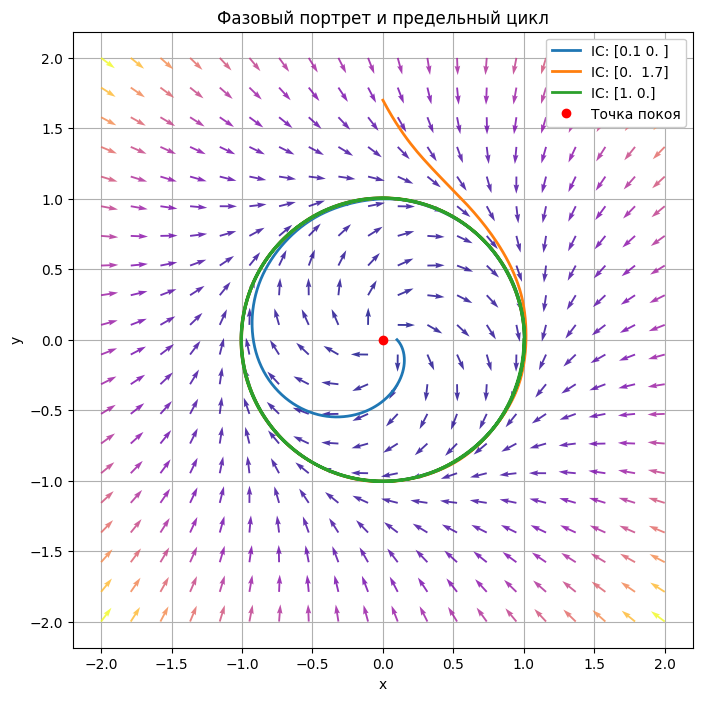

In [8]:
x_vals2 = np.linspace(-2, 2, 20)
y_vals2 = np.linspace(-2, 2, 20)
X2, Y2 = np.meshgrid(x_vals2, y_vals2)
dX2 = np.zeros_like(X2)
dY2 = np.zeros_like(Y2)

for i in range(X2.shape[0]):
    for j in range(X2.shape[1]):
        dx, dy = nonlinear_system(0, [X2[i, j], Y2[i, j]])
        dX2[i, j] = dx
        dY2[i, j] = dy

norm2 = np.sqrt(dX2**2 + dY2**2)
dX_scaled2 = dX2 / norm2
dY_scaled2 = dY2 / norm2

plt.figure(figsize=(8, 8))
plt.quiver(X2, Y2, dX_scaled2, dY_scaled2, norm2, cmap="plasma", alpha=0.8)

initial_conditions = [[0.1, 0], [0, 1.7], [1, 0]]

for ic in initial_conditions:
    sol = solve_ivp(nonlinear_system, [0, 20], ic, t_eval=np.linspace(0, 20, 1000))
    plt.plot(sol.y[0], sol.y[1], lw=2, label=f"IC: {sol.y[:,0]}")

for pt in equilibrium_points:
    x0 = float(pt[x])
    y0 = float(pt[y])
    plt.plot(x0, y0, 'ro', label="Точка покоя")

plt.title("Фазовый портрет и предельный цикл")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.legend(framealpha=1.0)
plt.gca().set_axisbelow(True) 
plt.axis('equal')
plt.grid(True)
plt.show()

Имеем единственный предельный цикл $x^2+y^2=1$ (притягивающий)
## Часть 3: Системы в полярных координатах 

$$
\begin{cases}
    \dot{\rho}=\rho(1-\rho)\\
    \dot{\varphi}=1-\cos{\varphi}
\end{cases}
$$

### Блок 3.1: Преобразование

In [9]:
def polar_system(t, state):
    r, theta = state
    drdt = r - r * r
    dthetadt = 1 - np.cos(theta)
    return np.array([drdt, dthetadt])

### Блок 3.2: Визуализация 

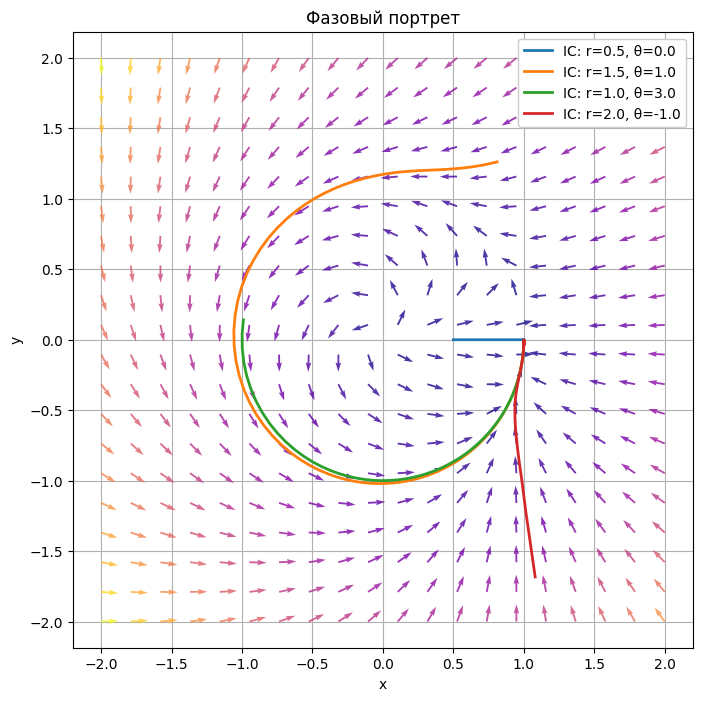

In [10]:
time_interval_3 = (0, 500)
initial_conditions3 = [[0.5, 0.0], [1.5, 1.0], [1.0, 3.0], [2.0, -1.0]]

solutions3 = []
plt.figure(figsize=(8, 8))

x_vals3 = np.linspace(-2, 2, 20)
y_vals3 = np.linspace(-2, 2, 20)
X3, Y3 = np.meshgrid(x_vals3, y_vals3)
dX3 = np.zeros_like(X3)
dY3 = np.zeros_like(Y3)

for i in range(X3.shape[0]):
    for j in range(X3.shape[1]):
        x = X3[i, j]
        y = Y3[i, j]
        r = np.sqrt(x**2 + y**2)
        theta = np.arctan2(y, x)
        dr, dtheta = polar_system(0, [r, theta])
        dx = dr * np.cos(theta) - r * dtheta * np.sin(theta)
        dy = dr * np.sin(theta) + r * dtheta * np.cos(theta)
        dX3[i, j] = dx
        dY3[i, j] = dy

norm3 = np.sqrt(dX3**2 + dY3**2)
dX3_scaled = dX3 / norm3
dY3_scaled = dY3 / norm3

plt.quiver(X3, Y3, dX3_scaled, dY3_scaled, norm3, cmap="plasma", alpha=0.8)

for ic in initial_conditions3:
    sol = solve_ivp(polar_system, time_interval_3, ic, t_eval=np.linspace(time_interval_3[0], time_interval_3[1], 10000))
    r, theta = sol.y
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    solutions3.append((x, y))
    plt.plot(x, y, lw=2, label=f"IC: r={ic[0]}, θ={ic[1]}")

plt.xlabel('x')
plt.ylabel('y')
plt.title('Фазовый портрет')
plt.grid(True)
plt.gca().set_axisbelow(True) 
plt.legend(framealpha=1.0)
plt.axis('equal')
plt.show()

Тут мы получили две точки покоя

## Часть 4: Рефлексия 

**Отдых - это время интересных фактов: в честь Александра Михайловича Ляпунова назван астероид ((5324) Ляпунов)**

## Часть 5: Системы в цилиндрических координатах (1 вариант)

Система: 
$$
\begin{cases}
\dot{r} = r(1 - z) \\
\dot{\theta} = 2 \\
\dot{z} = z(3 - r^2)
\end{cases}
$$

### Блок 5.1: Преобразование и визуализация 

In [ ]:
def cylindrical_system(t, state):
    r, theta, z = state
    drdt = r - r * z
    dthetadt = 2
    dzdt = 3 * z - z *  r**2
    return np.array([drdt, dthetadt, dzdt])

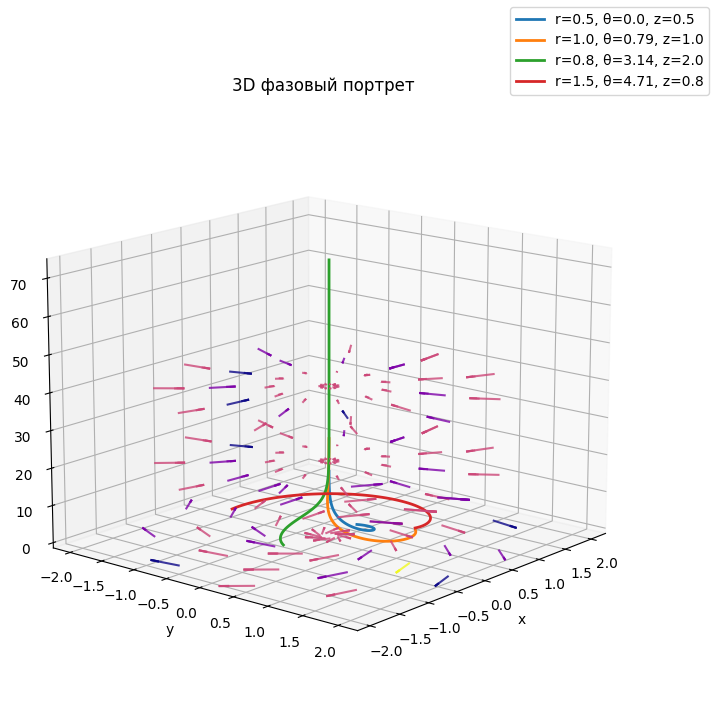

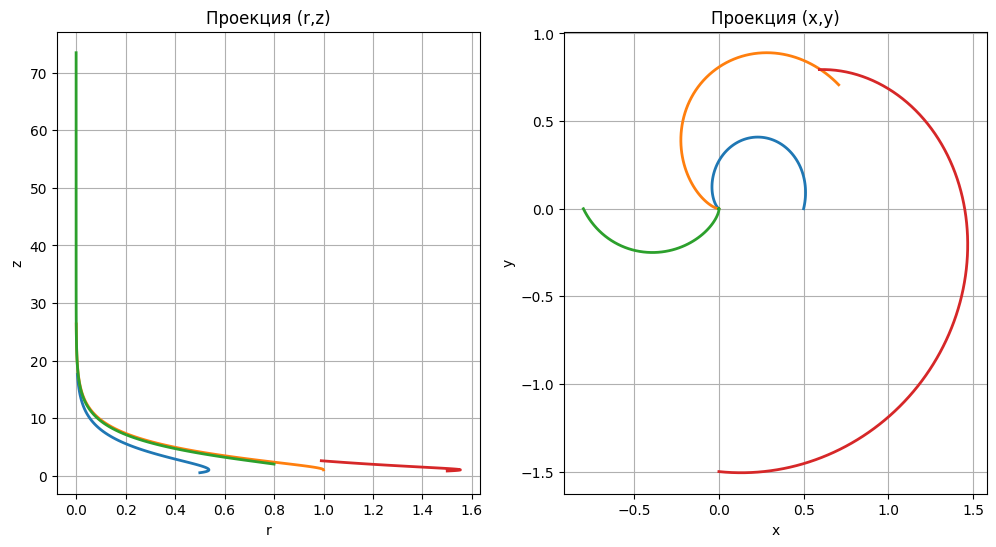

In [129]:
time_interval5 = (0, 1.25)
steps5 = 100
initial_conditions5 = [
    [0.5, 0.0, 0.5],
    [1.0, np.pi/4, 1.0],
    [0.8, np.pi, 2.0],
    [1.5, 3*np.pi/2, 0.8]
]

fig_3d = plt.figure(figsize=(8, 8))
ax_3d = fig_3d.add_subplot(1, 1, 1, projection='3d')

fig_2d = plt.figure(figsize=(12, 6))
ax_r_z = fig_2d.add_subplot(1, 2, 1)
ax_x_y = fig_2d.add_subplot(1, 2, 2)

for ic in initial_conditions5:
    sol = solve_ivp(cylindrical_system,
                    time_interval5, 
                    ic,
                    t_eval=np.linspace(time_interval5[0], time_interval5[1], steps5))
    
    r, theta, z = sol.y
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    
    ax_3d.plot(x, y, z, lw=2, label=f'r={ic[0]}, θ={round(ic[1], 2)}, z={ic[2]}')
    ax_r_z.plot(r, z, lw=2)
    ax_x_y.plot(x, y, lw=2)

ax_3d.set(xlabel='x', ylabel='y', zlabel='z', title='3D фазовый портрет')
fig_3d.legend(loc='upper right')
ax_3d.view_init(elev=15, azim=40)
ax_3d.invert_xaxis()
ax_r_z.set(xlabel='r', ylabel='z', title='Проекция (r,z)', aspect='equal')
ax_r_z.grid(True)
ax_r_z.set_axisbelow(True)
ax_r_z.set_aspect('auto') 
ax_x_y.set(xlabel='x', ylabel='y', title='Проекция (x,y)', aspect='equal')
ax_x_y.grid(True)
ax_x_y.set_axisbelow(True)
ax_x_y.set_aspect('auto')


r_vals = np.linspace(0.1, 2.0, 4)
theta_vals = np.linspace(0, 2*np.pi, 12)
z_vals = np.linspace(0.1, 40, 3)

R6, Theta, Z = np.meshgrid(r_vals, theta_vals, z_vals)
R6 = R6.flatten()
Theta = Theta.flatten()
Z = Z.flatten()

X6 = R6 * np.cos(Theta)
Y6 = R6 * np.sin(Theta)

drdt = R6 - R6 * Z
dthetadt = np.full_like(R6, 2.0)
dzdt = 3 * Z - Z * R6**2
dxdt = drdt * np.cos(Theta) - R6 * np.sin(Theta) * dthetadt
dydt = drdt * np.sin(Theta) + R6 * np.cos(Theta) * dthetadt
dzdt = dzdt
norm6 = np.sqrt(dxdt**2 + dydt**2 + dzdt**2)
dxdt /= norm6
dydt /= norm6
dzdt /= norm6

magnitude = np.sqrt(dxdt**2 + dydt**2 + dzdt**2)
norm6 = plt.Normalize(magnitude.min(), magnitude.max())
colors = cm.plasma(norm6(magnitude))
ax_3d.quiver(X6, Y6, Z, dxdt, dydt, dzdt, length=0.4, color=colors, alpha=0.8)

plt.show()

## Часть 6: Системы в сферических координатах (2 вариант)

Система: 
$$
\begin{cases}
\dot{r} = r(1 - r) \\
\dot{\theta} = \sin\theta \\
\dot{\phi} = 1
\end{cases}
$$

### Блок 6.1: Преобразование и визуализация

In [ ]:
def spherical_system(t, state):
    r, theta, phi = state
    # TODO: Реализуйте уравнения (используйте np.array)
    drdt = ...
    dthetadt = ...
    dphidt = ...
    return np.array([drdt, dthetadt, dphidt])

# TODO: Постройте 3D-фазовый портрет

## Часть 7: Автоматизация анализа 

Задача:  Функция для анализа устойчивости. Для программистов :)

In [ ]:
def analyze_stability(jacobian_matrix, equilibrium_point):
    # TODO:
    # 1. Вычислите собственные значения
    # 2. Определите тип точки покоя
    # 3. Верните результат в виде строки
    return "Тип устойчивости"